In [1]:
'''import zipfile
import os

# Path to the uploaded ZIP file
zip_path = "/content/data.zip"

# Extract contents to a target directory
extract_path = "/content/data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
print(os.listdir(extract_path))'''

'import zipfile\nimport os\n\n# Path to the uploaded ZIP file\nzip_path = "/content/data.zip"\n\n# Extract contents to a target directory\nextract_path = "/content/data"\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_path)\n\n# Verify extraction\nprint(os.listdir(extract_path))'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import models, layers, optimizers, losses, metrics
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from keras.optimizers import Adam

# Suppress TensorFlow warnings for clarity
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),  # Rotates images by a factor between -10% and +10%
    layers.RandomZoom(0.1),
])

In [5]:
labels_df = pd.read_csv('/content/data/kaggle/input/planets-dataset/planet/planet/train_classes.csv')
labels_df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [6]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))


There is 17 unique labels including {'blow_down', 'primary', 'haze', 'blooming', 'habitation', 'clear', 'agriculture', 'cloudy', 'bare_ground', 'partly_cloudy', 'cultivation', 'water', 'conventional_mine', 'artisinal_mine', 'selective_logging', 'slash_burn', 'road'}


<Axes: xlabel='count', ylabel='None'>

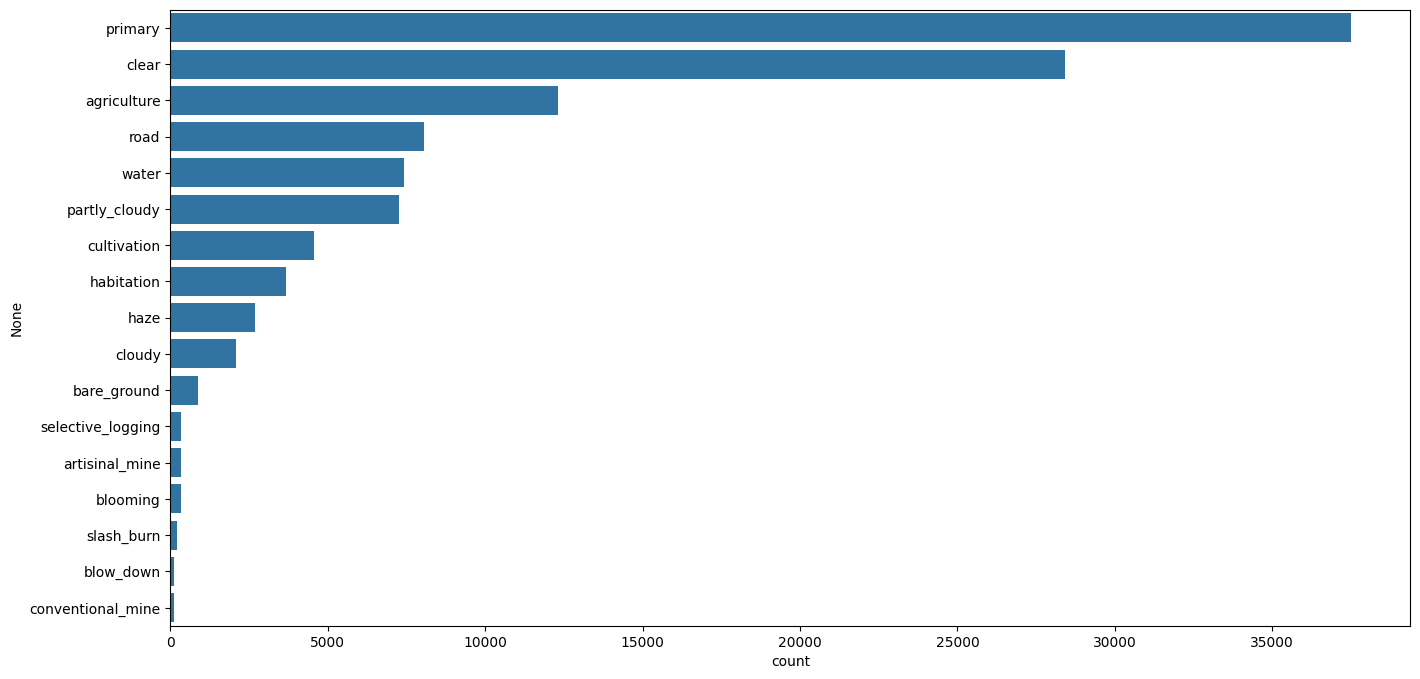

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')


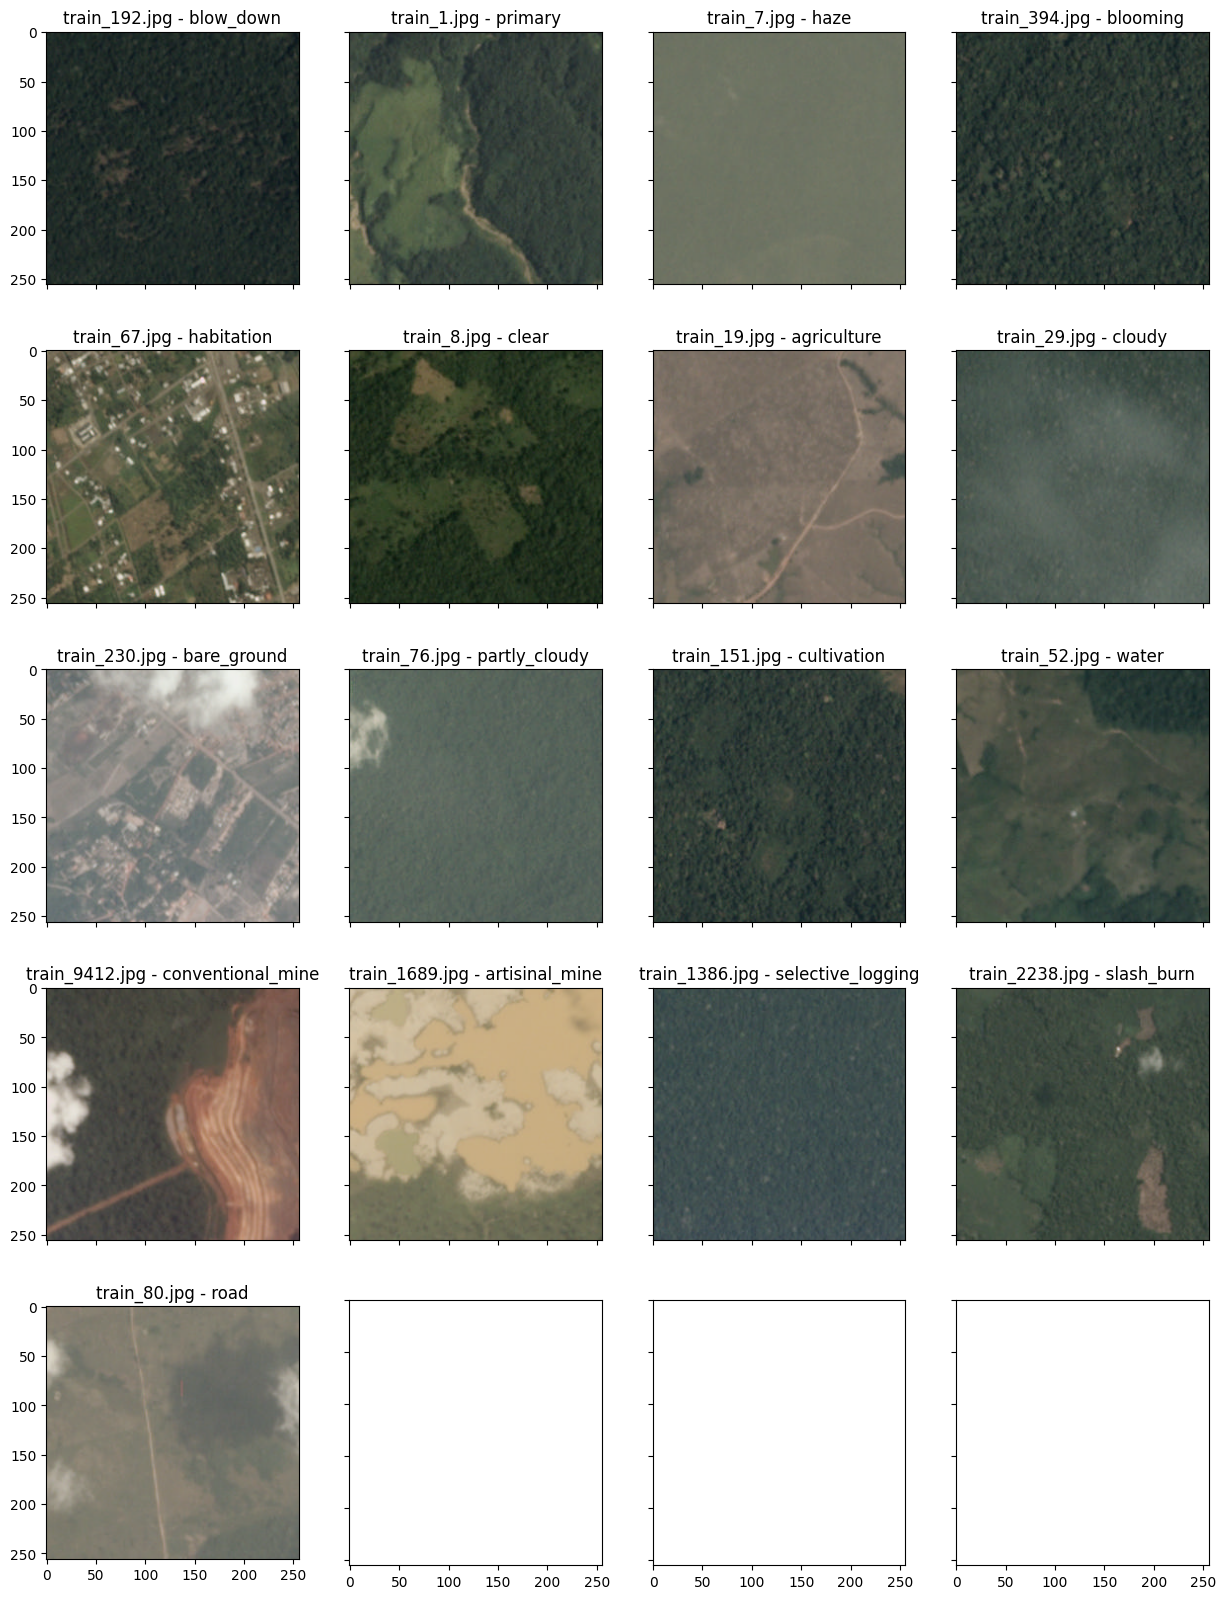

In [8]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg'
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread('/content/data/kaggle/input/planets-dataset/planet/planet/train-jpg' + '/' + image_name)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))


In [9]:
# Input parameters
train_jpeg_dir = '/content/data/kaggle/input/planets-dataset/planet/planet/train-jpg'
train_csv_file = '/content/data/kaggle/input/planets-dataset/planet/planet/train_classes.csv'
test_jpeg_dir = '/content/data/kaggle/input/planets-dataset/planet/planet/test-jpg'
test_additional_jpeg_dir = '/content/data/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional'
img_resize = (128, 128)  # Desired image size
validation_split = 0.2

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
# Step 1: Read Labels and File Paths
labels_df = pd.read_csv(train_csv_file)

# Step 2: Extract all unique labels
labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))

# Step 3: Create a mapping from label to index
labels_map = {label: idx for idx, label in enumerate(labels)}
num_classes = len(labels_map)

In [11]:
# Step 4: Map Labels to Integers and One-Hot Encode
def encode_tags(tags_str):
    tags = tags_str.split(' ')
    targets = np.zeros(num_classes, dtype='float32')
    for tag in tags:
        targets[labels_map[tag]] = 1.0
    return targets

labels_df['targets'] = labels_df['tags'].apply(encode_tags)

In [12]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Define the oversampling threshold
oversample_threshold = 3700  # Set your desired threshold value

# Explode the tags into individual rows for class-level operations
exploded_tags = labels_df['tags'].str.split(' ').explode()

# Get the current class counts
class_counts = exploded_tags.value_counts()

print("Class Distribution Before Oversampling:")
print(class_counts)

# Create a copy of the dataset
oversampled_df = labels_df.copy()

# Perform per-tag oversampling
for tag, count in class_counts.items():
    if count < oversample_threshold:  # Only oversample underrepresented tags
        print(f"Tag '{tag}' is underrepresented with count {count}. Oversampling to {oversample_threshold}...")

        # Filter rows containing the current tag
        class_df = oversampled_df[oversampled_df['tags'].str.contains(rf'\b{tag}\b')]

        # Calculate additional samples needed
        n_additional_samples = oversample_threshold - count

        # Oversample rows with the current tag
        additional_samples = resample(
            class_df,
            replace=True,
            n_samples=n_additional_samples,
            random_state=42
        )

        # Append oversampled rows
        oversampled_df = pd.concat([oversampled_df, additional_samples], ignore_index=True)

# Step 3: Verify Class Balance
final_class_counts = oversampled_df['tags'].str.split(" ").explode().value_counts()

print("Final Class Distribution After Oversampling:")
print(final_class_counts)


Class Distribution Before Oversampling:
tags
primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
Name: count, dtype: int64
Tag 'habitation' is underrepresented with count 3660. Oversampling to 3700...
Tag 'haze' is underrepresented with count 2697. Oversampling to 3700...
Tag 'cloudy' is underrepresented with count 2089. Oversampling to 3700...
Tag 'bare_ground' is underrepresented with count 862. Oversampling to 3700...
Tag 'selective_logging' is underrepresented with count 340. Oversampling to 3700...
Tag 'artisinal_mine' is underrepresented with count 339. Oversampling to 3700...
Tag

In [13]:
# Step 5: Split Data into Training and Validation Sets
train_df, val_df = train_test_split(oversampled_df, test_size=validation_split, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [14]:
# Step 6: Define the Pure Python Image Loading Function
def _load_image(path_str):
    """
    Load and preprocess an image from a given file path.

    Args:
        path_str (bytes): The file path as a bytes object.

    Returns:
        np.ndarray: The preprocessed image as a NumPy array.
    """
    try:
        from PIL import Image  # Import inside the function to ensure accessibility

        # Decode the bytes to a UTF-8 string
        path_str = path_str.decode('utf-8')

        # Open the image using PIL
        with Image.open(path_str) as img:
            # Convert image to RGB (handles CMYK and other modes)
            img = img.convert('RGB')
            # Resize the image
            img = img.resize(img_resize)
            # Convert to NumPy array and normalize to [0, 1]
            img_array = np.array(img).astype(np.float32) / 255.0
            # Normalize to [-1, 1]
            img_array = (img_array * 2.0) - 1.0

        return img_array
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        # Return a zero tensor as a placeholder to prevent pipeline failure
        return np.zeros([img_resize[0], img_resize[1], 3], dtype=np.float32)

In [15]:
# Step 7: Define the TensorFlow Wrapper Function using tf.numpy_function
def load_and_preprocess_image_numpy(path, label):
    """
    TensorFlow wrapper for loading and preprocessing an image using tf.numpy_function.

    Args:
        path (tf.Tensor): The file path as a TensorFlow string tensor.
        label (tf.Tensor): The corresponding label tensor.

    Returns:
        tuple: A tuple of the preprocessed image tensor and label tensor.
    """
    # Use tf.numpy_function to apply the pure Python _load_image function
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)

    # Set the shape of the image tensor
    image.set_shape([img_resize[0], img_resize[1], 3])

    return image, label

In [16]:
def augment_image(image, label):
    """
    Apply data augmentation to the image.

    Args:
        image (tf.Tensor): The input image tensor.
        label (tf.Tensor): The corresponding label tensor.

    Returns:
        tuple: The augmented image tensor and the original label tensor.
    """
    image = data_augmentation(image)
    return image, label

In [17]:
# Step 8: Define the Dataset Creation Function using tf.numpy_function
def create_dataset_numpy(df, training=True):
    """
    Create a TensorFlow dataset from a DataFrame using tf.numpy_function.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        training (bool): Whether the dataset is for training (enables shuffling).

    Returns:
        tf.data.Dataset: The prepared dataset.
    """
    # Construct full file paths
    image_paths = df['image_name'].apply(lambda x: os.path.join(train_jpeg_dir, f"{x}.jpg")).tolist()
    labels = np.stack(df['targets'].values)

    # Create a TensorFlow Dataset from the file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Map the load_and_preprocess_image_numpy function to the dataset
    dataset = dataset.map(load_and_preprocess_image_numpy, num_parallel_calls=AUTOTUNE)

    if training:
        # Shuffle the dataset for training
        dataset = dataset.shuffle(buffer_size=1000)
        # Apply data augmentation
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

    # Batch and prefetch the dataset for optimal performance
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

    return dataset


In [18]:
# Step 9: Create Training and Validation Datasets using tf.numpy_function
train_dataset_numpy = create_dataset_numpy(train_df, training=True)
val_dataset_numpy = create_dataset_numpy(val_df, training=False)

In [19]:
# Step 10: Verify the Datasets
print("\nVerifying Training Dataset with tf.numpy_function:")
for images, labels in train_dataset_numpy.take(1):
    print("Image tensor shape:", images.shape)
    print("Image tensor dtype:", images.dtype)
    print("Image tensor min value:", tf.reduce_min(images).numpy())
    print("Image tensor max value:", tf.reduce_max(images).numpy())
    print("Image tensor mean value:", tf.reduce_mean(images).numpy())
    break



Verifying Training Dataset with tf.numpy_function:
Image tensor shape: (32, 128, 128, 3)
Image tensor dtype: <dtype: 'float32'>
Image tensor min value: -0.9654646
Image tensor max value: 0.9579478
Image tensor mean value: -0.3589584


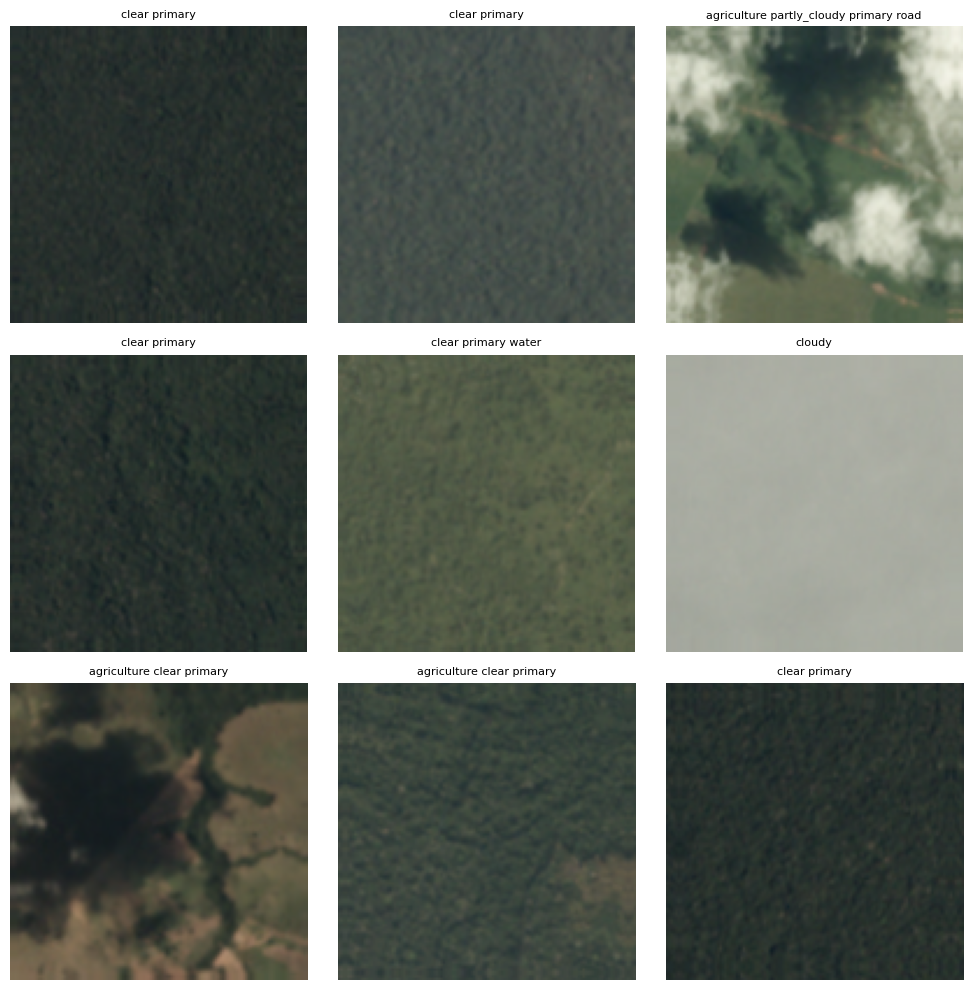

In [20]:
# Step 11: Plot a Batch of Images to Confirm
# Create a reverse mapping from index to label
index_to_label = {idx: label for label, idx in labels_map.items()}

def decode_label(one_hot_label):
    indices = np.where(one_hot_label == 1)[0]
    tags = [index_to_label[idx] for idx in indices]
    return " ".join(tags)

# Extract one batch of images and labels from the training dataset
for images, labels in train_dataset_numpy.take(1):
    images_np = images.numpy()
    labels_np = labels.numpy()
    break

# Convert images from [-1, 1] to [0, 1] for visualization
images_np = (images_np + 1.0) / 2.0

# Plot the images with labels
num_images_to_display = 9
plt.figure(figsize=(10, 10))

for i in range(num_images_to_display):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_np[i])
    plt.axis("off")
    # Decode the label
    label = decode_label(labels_np[i])
    ax.set_title(label, fontsize=8)
plt.tight_layout()
plt.show()

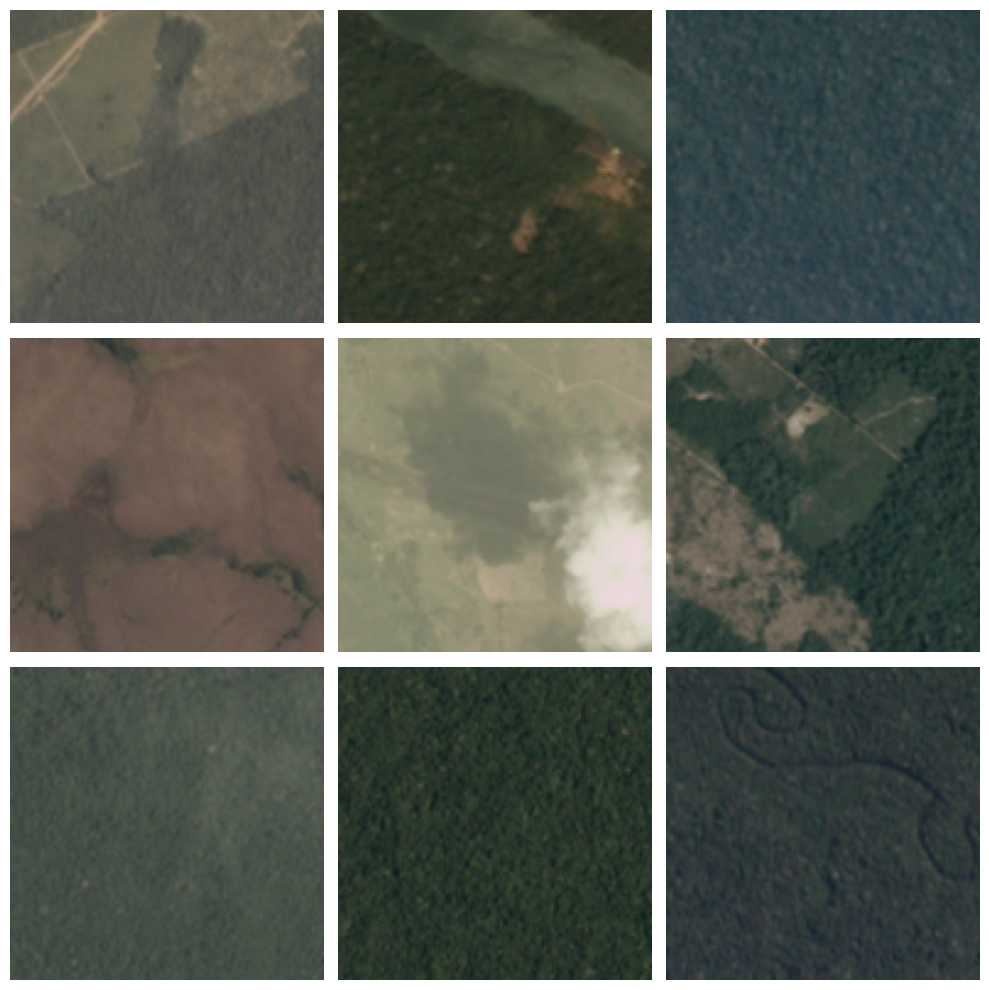

In [21]:
# Step 12: Create Test Dataset using tf.numpy_function and PIL-based Loader
def load_and_preprocess_test_image_numpy(path):
    """
    TensorFlow wrapper for loading and preprocessing test images using tf.numpy_function.

    Args:
        path (tf.Tensor): The file path as a TensorFlow string tensor.

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    # Use tf.numpy_function to apply the pure Python _load_image function
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)

    # Set the shape of the image tensor
    image.set_shape([img_resize[0], img_resize[1], 3])

    return image

# Get test file paths
test_files = [os.path.join(test_jpeg_dir, f) for f in os.listdir(test_jpeg_dir)]
test_files += [os.path.join(test_additional_jpeg_dir, f) for f in os.listdir(test_additional_jpeg_dir)]

# Create test dataset using the PIL-based loader
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_and_preprocess_test_image_numpy, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

# (Optional) Visualize Test Images Without Labels
num_test_images_to_display = 9
plt.figure(figsize=(10, 10))

for images in test_dataset.take(1):
    test_images_np = images.numpy()
    # Convert images from [-1, 1] to [0, 1] for visualization
    test_images_np = (test_images_np + 1.0) / 2.0
    break

for i in range(num_test_images_to_display):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images_np[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [22]:
import tensorflow.keras.backend as K

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # Clipping y_pred between 0 and 1
    y_pred = K.clip(y_pred, 0, 1)

    # Rounding y_pred to binary values
    y_pred_bin = K.round(y_pred + threshold_shift)

    # Counting true positives, false positives, and false negatives
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculating precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


In [23]:
# Step 13: Convert dataset into numpy arrays
x_train_data = []
y_train_data = []

x_test_data = []
y_test_data = []

for x_batch, y_batch in train_dataset_numpy:
    x_train_data.append(x_batch.numpy())  # Add images to list
    y_train_data.append(y_batch.numpy())  # Add labels to list

for x_batch, y_batch in val_dataset_numpy:
    x_test_data.append(x_batch.numpy())  # Add images to list
    y_test_data.append(y_batch.numpy())  # Add labels to list

# Concatenate to get all data
x_train_data = np.concatenate(x_train_data, axis=0)
y_train_data = np.concatenate(y_train_data, axis=0)
x_test_data = np.concatenate(x_test_data, axis=0)
y_test_data = np.concatenate(y_test_data, axis=0)

print("All images (x):", x_test_data.shape)
print("All labels (y):", y_test_data.shape)
'''
# Step 14: Build the Model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_resize[0], img_resize[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(num_classes, activation='sigmoid')  # Use softmax for multi-class classification
])


'''
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_resize[0], img_resize[1], 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])
'''
model = tf.keras.Sequential([
    # Input normalization
    BatchNormalization(input_shape=(128, 128, 3)),  # Adjust based on your input shape

    # First Convolutional Block
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Second Convolutional Block
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(17, activation='sigmoid')  # 17 output classes for multi-label classification
])
#'''

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[fbeta]
)

model.summary()  # Display the model summary

# Train the Model
history = model.fit(
    x_train_data,
    y_train_data,
    epochs=10,
    batch_size=batch_size,
    validation_split=0.2)


All images (x): (13350, 128, 128, 3)
All labels (y): (13350, 17)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                       

In [24]:
# Step 15: Evaluate the Model
from sklearn.metrics import fbeta_score

model.evaluate(val_dataset_numpy)

train_fscore = fbeta_score(y_train_data, np.round(model.predict(x_train_data)), beta=2, average='weighted')
print(f'Training fbeta: {train_fscore}')

val_fscore = fbeta_score(y_test_data, np.round(model.predict(x_test_data)), beta=2, average='weighted')
print(f'Validation fbeta: {val_fscore}')

#print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

1669/1669 [==============================] - 44s 26ms/step
Training fbeta: 0.8949881248678079
418/418 [==============================] - 11s 25ms/step
Validation fbeta: 0.8513600721336065


In [25]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred_prob = model.predict(x_test_data)

# Create different probability thresholds depending on the amount of samples for each class
thresholds = [0.5, 0.1, 0.3, 0.1, 0.1, .5, .4, .1, .4, .4, .4,  .5, .5, .5, .2, .2, .5]  # Custom threshold for each class
predicted_classes = np.array([pred > threshold for pred, threshold in zip(y_pred_prob.T, thresholds)]).T.astype(int)

y_pred = (y_pred_prob > 0.5).astype(int)

418/418 [==============================] - 11s 26ms/step


In [26]:
print(classification_report(y_test_data, y_pred, target_names=labels_map))


                   precision    recall  f1-score   support

      agriculture       0.68      0.77      0.72      3547
   artisinal_mine       0.91      0.86      0.88       916
      bare_ground       0.86      0.66      0.75      1843
         blooming       0.60      0.69      0.64       815
        blow_down       0.81      0.78      0.80       791
            clear       0.95      0.97      0.96      9799
           cloudy       0.91      0.74      0.81       724
conventional_mine       0.91      0.91      0.91       724
      cultivation       0.68      0.54      0.60      1672
       habitation       0.64      0.63      0.64      1335
             haze       0.69      0.58      0.63       803
    partly_cloudy       0.90      0.87      0.88      2024
          primary       0.97      0.99      0.98     12282
             road       0.71      0.81      0.76      2948
selective_logging       0.80      0.73      0.77      1205
       slash_burn       0.82      0.73      0.77      1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
thresholds = [0.5, 0.15, 0.3, 0.15, 0.15, .5, .2, .03, .25, .45, .25, .4, .5, .5, .1, .06, .35]  # Custom threshold for each class
predicted_classes = np.array([pred > threshold for pred, threshold in zip(y_pred_prob.T, thresholds)]).T.astype(int)
print(classification_report(y_test_data, predicted_classes, target_names=labels_map))

                   precision    recall  f1-score   support

      agriculture       0.68      0.77      0.72      3547
   artisinal_mine       0.86      0.92      0.89       916
      bare_ground       0.78      0.73      0.75      1843
         blooming       0.39      0.83      0.54       815
        blow_down       0.60      0.89      0.72       791
            clear       0.95      0.97      0.96      9799
           cloudy       0.83      0.88      0.85       724
conventional_mine       0.71      0.97      0.82       724
      cultivation       0.51      0.69      0.59      1672
       habitation       0.62      0.66      0.64      1335
             haze       0.58      0.67      0.62       803
    partly_cloudy       0.89      0.88      0.88      2024
          primary       0.97      0.99      0.98     12282
             road       0.71      0.81      0.76      2948
selective_logging       0.56      0.88      0.69      1205
       slash_burn       0.52      0.88      0.65      1

{'agriculture': {'precision': 0.6844489179667841, 'recall': 0.7668452213137863, 'f1-score': 0.7233080707352746, 'support': 3547.0}, 'artisinal_mine': {'precision': 0.8556910569105691, 'recall': 0.9192139737991266, 'f1-score': 0.8863157894736842, 'support': 916.0}, 'bare_ground': {'precision': 0.7759216589861752, 'recall': 0.7308735756918069, 'f1-score': 0.7527242246437552, 'support': 1843.0}, 'blooming': {'precision': 0.3947521865889213, 'recall': 0.8306748466257668, 'f1-score': 0.5351778656126482, 'support': 815.0}, 'blow_down': {'precision': 0.6001705029838023, 'recall': 0.8900126422250316, 'f1-score': 0.7169042769857433, 'support': 791.0}, 'clear': {'precision': 0.9534744408945687, 'recall': 0.9745892438003878, 'f1-score': 0.9639162250820086, 'support': 9799.0}, 'cloudy': {'precision': 0.8279009126466753, 'recall': 0.8770718232044199, 'f1-score': 0.85177733065057, 'support': 724.0}, 'conventional_mine': {'precision': 0.7087967644084934, 'recall': 0.9682320441988951, 'f1-score': 0.81

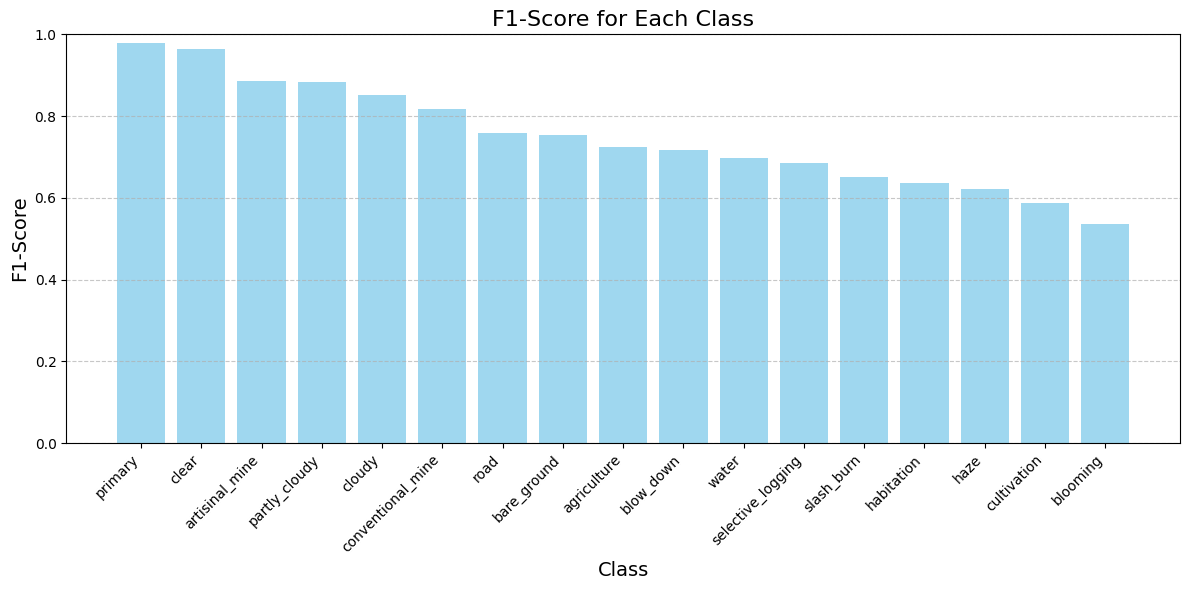

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Example classification report (dictionary format or generated from sklearn)
report = classification_report(y_test_data, predicted_classes, target_names=labels_map, output_dict=True)
print(report)
class_f1_scores = {
    k: v["f1-score"] for k, v in report.items() if k not in ["micro avg", "macro avg", "weighted avg", "samples avg"]
}

sorted_scores = sorted(class_f1_scores.items(), key=lambda item: item[1], reverse=True)  # Sort by F1 score descending
classes, f1_scores = zip(*sorted_scores)


plt.figure(figsize=(12, 6))
plt.bar(classes, f1_scores, color="skyblue", alpha=0.8)
plt.title("F1-Score for Each Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0, 1)  # F1-scores range between 0 and 1
plt.xticks(rotation=45, ha="right")  # Rotate class names for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

{'agriculture': {'precision': 0.6844489179667841, 'recall': 0.7668452213137863, 'f1-score': 0.7233080707352746, 'support': 3547.0}, 'artisinal_mine': {'precision': 0.8556910569105691, 'recall': 0.9192139737991266, 'f1-score': 0.8863157894736842, 'support': 916.0}, 'bare_ground': {'precision': 0.7759216589861752, 'recall': 0.7308735756918069, 'f1-score': 0.7527242246437552, 'support': 1843.0}, 'blooming': {'precision': 0.3947521865889213, 'recall': 0.8306748466257668, 'f1-score': 0.5351778656126482, 'support': 815.0}, 'blow_down': {'precision': 0.6001705029838023, 'recall': 0.8900126422250316, 'f1-score': 0.7169042769857433, 'support': 791.0}, 'clear': {'precision': 0.9534744408945687, 'recall': 0.9745892438003878, 'f1-score': 0.9639162250820086, 'support': 9799.0}, 'cloudy': {'precision': 0.8279009126466753, 'recall': 0.8770718232044199, 'f1-score': 0.85177733065057, 'support': 724.0}, 'conventional_mine': {'precision': 0.7087967644084934, 'recall': 0.9682320441988951, 'f1-score': 0.81

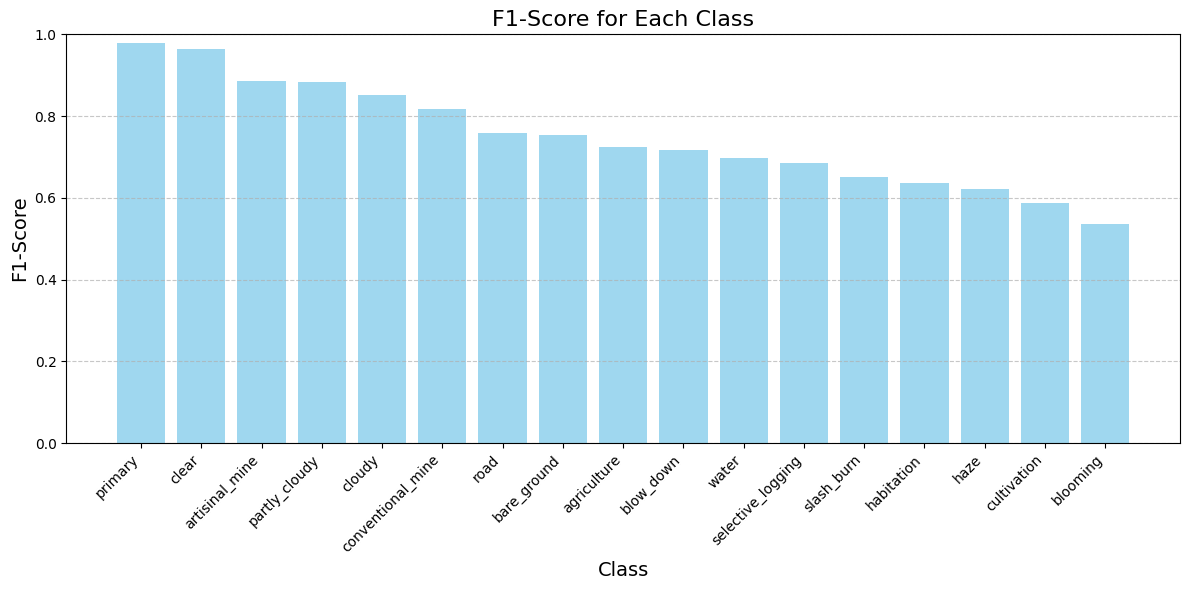

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Example classification report (dictionary format or generated from sklearn)
report = classification_report(y_test_data, predicted_classes, target_names=labels_map, output_dict=True)
print(report)
class_f1_scores = {
    k: v["f1-score"] for k, v in report.items() if k not in ["micro avg", "macro avg", "weighted avg", "samples avg"]
}

sorted_scores = sorted(class_f1_scores.items(), key=lambda item: item[1], reverse=True)  # Sort by F1 score descending
classes, f1_scores = zip(*sorted_scores)


plt.figure(figsize=(12, 6))
plt.bar(classes, f1_scores, color="skyblue", alpha=0.8)
plt.title("F1-Score for Each Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0, 1)  # F1-scores range between 0 and 1
plt.xticks(rotation=45, ha="right")  # Rotate class names for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()